In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import dvu
from neuro.flatmaps_helper import load_flatmaps
from neuro.features.questions.gpt4 import QS_35_STABLE
import sys
import warnings
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR
from neuro.config import repo_dir, PROCESSED_DIR
from neuro import analyze_helper, viz
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
# flatmaps_per_question = __import__('06_flatmaps_per_question')
import viz
import gemv
from neuro.flatmaps_helper import load_flatmaps
from statsmodels.stats.multitest import multipletests

Note, this notebook requires first running `03_export_qa_flatmaps.ipynb` into `df_qa_dict.pkl` files for each subject.

### load gemv average flatmaps

In [2]:
gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03 = load_flatmaps(
    normalize_flatmaps=False, load_timecourse=False)
# gemv_flatmaps_pilot | gemv_flatmaps_pilot5
gemv_flatmaps_dict = gemv_flatmaps_dict_S02
qa_questions_list, gemv_questions_list = gemv.get_matched_lists()
assert len(qa_questions_list) == len(gemv_questions_list)
assert len(qa_questions_list) == 35

### make comparisons

In [3]:
# # check that gpt4 was run for all the questions
# subject = 'UTS02'
# setting = 'individual_gpt4'
# flatmaps_qa = joblib.load(
#     join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
# for k in qa_list:
#     assert k in flatmaps_qa.keys()

settings = ['individual_gpt4', 'individual_gpt4_wordrate',
            'shapley_35']  # main one!!!!!!!!!!


# settings = ['full_35']
# settings = ['full_35_wordrate']
# settings = ['full_35_pc']
# settings = ['full_neurosynth']
# settings = ['full_35_gpt4_pc']
# settings = ['individual_gpt4_pc']
# settings = ['shapley_35_gpt4_pc']
# settings = ['shapley_35', 'individual_gpt4_pc', 'shapley_35_gpt4_pc']
# settings = ['individual_gpt4_ndel=1_pc']
# settings = ['full_35_gpt4_ndel=1_pc']
# settings = ['full_35_ndel=8_pc']
# settings = ['full_35', 'full_35_wordrate']
# settings = ['individual_gpt4', 'individual_gpt4_wordrate',]
# settings = ['individual_gpt4_ndel=8_new', 'individual_gpt4_wordrate', 'shapley_35']
# settings = ['shapley_35']
# settings = ['individual_35']
# settings = ['individual_gpt4']
# , 'individual_35', full_35', 'shapley_35', 'individual_gpt4',
# for setting in ['individual_gpt4', 'shapley_35']:
# for setting in ['individual_gpt4', 'individual_gpt4_wordrate']:
# , 'shapley_35']:
# for setting in ['individual_gpt4']:
# for setting in ['individual_gpt4', 'individual_gpt4_wordrate']:
# , 'individual_gpt4', 'individual_gpt4_wordrate']:

# corrs_mask_per_question = False
corrs_mask_per_question = False

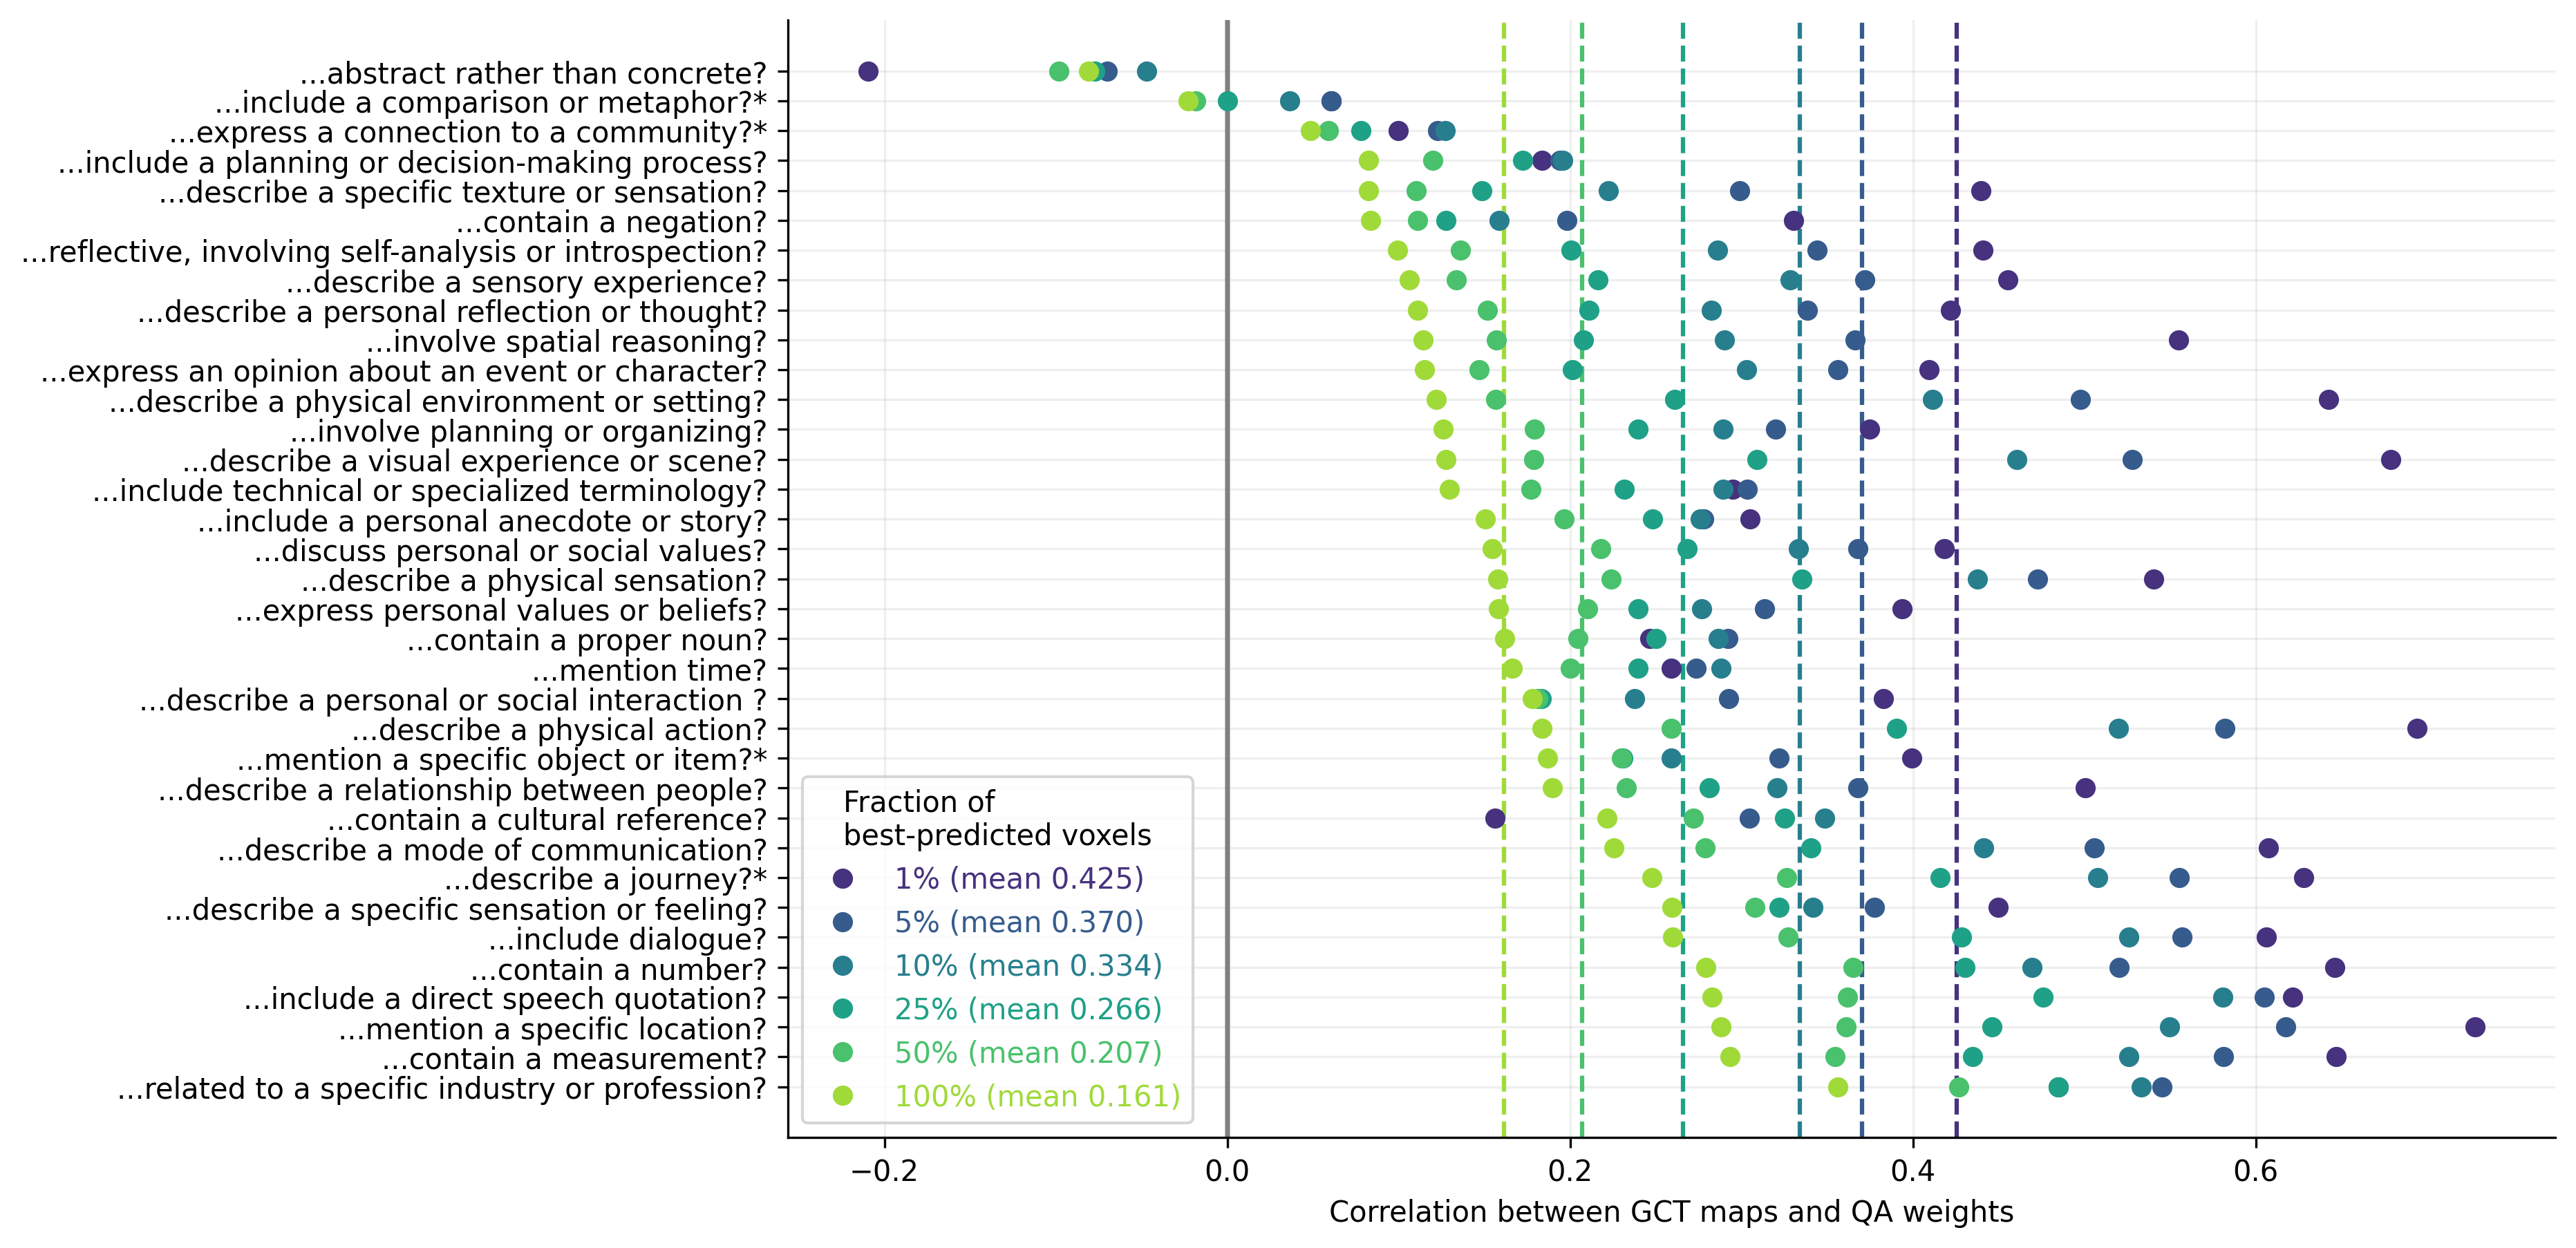

In [9]:
# load qa weights
subject = 'UTS02'
corrs_df_dict = {}
frac_voxels_to_keep_list = [0.01, 0.05, 0.1, 0.25, 0.5, 1]

# corrs used for masking
corrs_test = joblib.load(join(PROCESSED_DIR, subject.replace(
    'UT', ''), 'corrs_test_35.pkl')).values[0]
corrs_test_individual_dict = joblib.load(join(PROCESSED_DIR, subject.replace(
    'UT', ''), 'corrs_test_individual_gpt4_qs_35.pkl'))

for j, frac_voxels_to_keep in enumerate(frac_voxels_to_keep_list):
    flatmaps_qa_list = defaultdict(list)
    for setting in settings:
        flatmaps_qa_dict = joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
        for q in flatmaps_qa_dict.keys():
            flatmaps_qa_list[q].append(flatmaps_qa_dict[q])
    # print('lens', [len(flatmaps_qa_list[q]) for q in flatmaps_qa_list.keys()])
    flatmaps_qa_dict = {
        q: np.mean(flatmaps_qa_list[q], axis=0)
        # q: np.max(flatmaps_qa_list[q], axis=0)
        # q: np.median(flatmaps_qa_list[q], axis=0)
        for q in flatmaps_qa_list.keys()}

    # select what to plot
    # df_qa_dict = joblib.load(f'df_qa_dict_{subject.replace("UT", "")}.pkl')
    questions_names_df = pd.DataFrame({
        'qa': qa_questions_list,
        'gemv': gemv_questions_list,
    })
    # filter only questions that exist in the flatmaps
    questions_names_df = questions_names_df[questions_names_df['qa'].isin(
        flatmaps_qa_dict.keys())]

    if isinstance(flatmaps_qa_dict, pd.DataFrame):
        questions_names_df = questions_names_df[questions_names_df['qa'].isin(
            flatmaps_qa_dict.index)]
        flatmaps_qa_list = flatmaps_qa_dict.loc[questions_names_df['qa'].values]['weights'].values
    else:
        flatmaps_qa_list = [flatmaps_qa_dict[q]
                            for q in questions_names_df['qa'].values]
    flatmaps_gemv_list = [
        gemv_flatmaps_dict[q]
        for q in questions_names_df['gemv'].values]
    titles_gt = questions_names_df['gemv'].apply(
        lambda x: x[0]).astype(str)

    # mask flatmaps by corr
    # corrs_test = joblib.load(join(PROCESSED_DIR, subject.replace(
    #     'UT', ''), 'corrs_test_35.pkl')).values[0]
    # corrs_test_mask = (corrs_test >= np.percentile(
    #     corrs_test, 100 * (1 - frac_voxels_to_keep))).astype(bool)

    # flatmaps_qa = [flatmaps_qa[i][corrs_test_mask]
    #                for i in range(len(flatmaps_qa))]
    # flatmaps_gemv = [flatmaps_gemv[i][corrs_test_mask]
    #                  for i in range(len(flatmaps_gemv))]

    # mask flatmaps by extreme vals
    for i in range(len(flatmaps_qa_list)):
        if frac_voxels_to_keep < 1:
            # mask based on extreme values
            # mask = np.abs(flatmaps_qa_list[i]) >= np.percentile(
            #     np.abs(flatmaps_qa_list[i]), 100 * (1 - frac_voxels_to_keep))

            # mask based on corrs
            if corrs_mask_per_question:
                q = questions_names_df['qa'].values[i]
                mask = (corrs_test_individual_dict[q] > np.percentile(
                    corrs_test_individual_dict[q], 100 * (1 - frac_voxels_to_keep))).astype(bool)
            else:
                mask = (corrs_test > np.percentile(
                    corrs_test, 100 * (1 - frac_voxels_to_keep))).astype(bool)
        else:
            mask = np.ones_like(flatmaps_qa_list[i]).astype(bool)

        flatmaps_qa_list[i] = flatmaps_qa_list[i][mask]
        flatmaps_gemv_list[i] = flatmaps_gemv_list[i][mask]

    # # save flatmaps
    # if frac_voxels_to_keep in [0.1, 1]:

    #     # apply mask as nans
    #     for i in range(len(flatmaps_qa)):
    #         flatmaps_qa[i][~corrs_test_mask] = np.nan
    #         flatmaps_gemv[i][~corrs_test_mask] = np.nan

    #     for i in tqdm(range(len(flatmaps_qa))):
    #         sasc.viz.quickshow(
    #             flatmaps_qa[i],
    #             subject=subject,
    #             fname_save=join(repo_dir, 'qa_results', 'gemv', subject,
    #                             f'frac_voxels={frac_voxels_to_keep}',
    #                             setting, f'{titles_gt[i]}.png'),
    #             cmap='RdYlBu_r',
    #         )

    #         sasc.viz.quickshow(
    #             flatmaps_gemv[i],
    #             subject=subject,
    #             fname_save=join(repo_dir, 'qa_results', 'gemv', subject,
    #                             f'frac_voxels={frac_voxels_to_keep}',
    #                             'gemv', f'{titles_gt[i]}.png'),
    #             cmap='RdYlBu_r',
    #         )

    # shuffle gemv
    # random.shuffle(flatmaps_gemv)

    # print num nas
    # print('nas', [np.isnan(flatmaps_gemv[i]).sum()
    #   for i in range(len(flatmaps_gemv))])

    corrs_mat = viz._calc_corrs(
        flatmaps_qa_list,
        flatmaps_gemv_list,
        titles_qa=[analyze_helper.abbrev_question(q)
                   for q in questions_names_df['qa'].astype(str)],
        titles_gt=titles_gt,
    )
    # corrs_df = pd.DataFrame({'corrs': np.diag(
    # corrs.values), 'questions': corrs.columns}).sort_values('corrs', ascending=False)
    # corrs_df_dict[frac_voxels_to_keep] = corrs_df.copy()
    # corrs_df_dict['questions'] = corrs_mat.columns
    qs = [analyze_helper.abbrev_question(
        q) for q in questions_names_df['qa'].values]
    for i, q in enumerate(qs):
        for l in gemv.LOOSE_MATCHES:
            if analyze_helper.abbrev_question(l) == q:
                qs[i] += '*'
    corrs_df_dict['questions'] = qs
    corrs_df_dict[f'corrs_{frac_voxels_to_keep}'] = np.diag(corrs_mat.values)


# actually make plot
corrs_df = pd.DataFrame(corrs_df_dict)
corrs_df = corrs_df.sort_values('corrs_1', ascending=False)
# corrs_df.to_pickle(join(repo_dir, 'qa_results', 'gemv',
# setting + '_corrs_df.pkl'))
plt.figure(figsize=(11, 7), dpi=300)
for j, frac_voxels_to_keep in enumerate(frac_voxels_to_keep_list):
    colors = sns.color_palette('viridis', len(frac_voxels_to_keep_list))
    viz.corr_bars(
        corrs_df['corrs_' + str(frac_voxels_to_keep)],
        questions=corrs_df['questions'],
        out_dir_save=join(repo_dir, 'qa_results', 'gemv',
                          'corrs_' + setting),
        xlab='Correlation between GCT maps and QA weights',
        color=colors[j],
        # label=f'{frac_voxels_to_keep * 100:.2f}%',
        label=f'{int(frac_voxels_to_keep * 100)}%',
    )
    # plt.savefig(join(out_dir_save, 'corrs_barplot.pdf'), bbox_inches='tight')
    # plt.savefig(join(out_dir_save, 'corrs_barplot.png'),
    #             bbox_inches='tight', dpi=300)
    # plt.show()

# plt.title('___'.join(settings))
# center legend text
plt.legend(title='Fraction of\nbest-predicted voxels',
           labelcolor='linecolor')
# plt.tight_layout()
# plt.savefig(join(repo_dir, 'qa_results', 'gemv', subject, 'corrs_barplot.pdf'),
# bbox_inches='tight')
out_fname = 'corrs_' + '___'.join(settings)
if corrs_mask_per_question:
    out_fname += '_mask_per_question'
plt.savefig(join(repo_dir, 'qa_results', 'gemv', subject, out_fname + '.png'),
            bbox_inches='tight', dpi=300)
plt.savefig(join(repo_dir, 'qa_results', 'gemv', subject, out_fname + '.pdf'),
            bbox_inches='tight', dpi=300)
joblib.dump(corrs_df, join(repo_dir, 'qa_results', 'gemv',
                           subject, out_fname + '.pkl'))
plt.show()

In [11]:
joblib.dump(corrs_df, 'corrs_df/gemv.pkl')

['corrs_df/gemv.pkl']

In [23]:
corrs_df
# corrs_df.questions.apply(gemv.abbrev_question_to_original).values

,questions,corrs_0.01,corrs_0.05,corrs_0.1,corrs_0.25,corrs_0.5,corrs_1
7,...related to a specific industry or profession?,0.484911,0.545333,0.533160,0.484740,0.426602,0.356287
1,...contain a measurement?,0.646869,0.581266,0.526034,0.434947,0.354679,0.293160
2,...mention a specific location?,0.727854,0.617503,0.549756,0.445887,0.361092,0.288093
32,...include a direct speech quotation?,0.621610,0.605002,0.580742,0.476051,0.361910,0.282815
9,...contain a number?,0.646063,0.520113,0.469545,0.430197,0.365070,0.279039
6,...include dialogue?,0.606055,0.556876,0.525724,0.428355,0.327143,0.259636
26,...describe a specific sensation or feeling?,0.449804,0.377581,0.341750,0.321860,0.307877,0.259555
30,...describe a journey?*,0.627821,0.555213,0.507804,0.415940,0.326513,0.247556
3,...describe a mode of communication?,0.607142,0.505605,0.441113,0.340346,0.278727,0.225469
5,...contain a cultural reference?,0.156362,0.304745,0.348302,0.325171,0.271822,0.221440


In [ ]:
# aggregate results
corrs_results_dir = join(repo_dir, 'qa_results', 'gemv', subject)
d = defaultdict(list)
for fname in os.listdir(corrs_results_dir):
    if fname.startswith('corrs_') and fname.endswith('.pkl'):
        d['setting'].append(fname.replace('corrs_', '').replace('.pkl', ''))
        x = joblib.load(join(corrs_results_dir, fname))
        d['corrs_df'].append(joblib.load(join(corrs_results_dir, fname)))
        if not len(x) == len(gemv_questions_list):
            warnings.warn(
                'not all questions were computed for ' + str(d['setting'][-1]))
# assert all([x.shape[0] == d['corrs_df'][0].shape[0] for x in d['corrs_df']])
avg_df = pd.DataFrame([x.drop(columns='questions').mean(axis=0)
                      for x in d['corrs_df']], index=d['setting'])
avg_df = avg_df.sort_values(by='corrs_1', ascending=False)
avg_df.style.background_gradient(cmap='viridis').format("{:.3f}")

### compute p-values with eng1000

In [71]:
for frac_voxels_to_keep in tqdm(frac_voxels_to_keep_list):
    # eng1000_dir = join(PROCESSED_DIR, subject.replace(
    # 'UT', ''), 'eng1000_weights.pkl')
    # flatmaps_null = joblib.load(eng1000_dir)
    flatmaps_null = np.array(joblib.load(
        # join(PROCESSED_DIR, subject.replace('UT', ''), 'resp_chunks_20trs.pkl')))
        # join(PROCESSED_DIR, subject.replace('UT', ''), 'resp_chunks_10trs.pkl')))
        join(PROCESSED_DIR, subject.replace('UT', ''), 'resp_chunks_1trs.pkl')))

    # print('shape', flatmaps_eng1000.shape)
    pvals, baseline_distr = viz.compute_pvals(
        flatmaps_qa_list, frac_voxels_to_keep,
        corrs_df[f'corrs_{frac_voxels_to_keep}'].values,
        flatmaps_null=flatmaps_null, mask_corrs=corrs_test)

    # get what fraction of 'corrs_perm_eng1000' column is greater than 'corrs'
    corrs_df[f'pval_{frac_voxels_to_keep}'] = pvals
    corrs_df[f'baseline_distr_{frac_voxels_to_keep}'] = baseline_distr
for frac_voxels_to_keep in tqdm(frac_voxels_to_keep_list):
    corrs_df[f'pval_{frac_voxels_to_keep}_err_corrected'] = multipletests(
        pvals, method='fdr_bh', alpha=0.05)[1]

100%|██████████| 6/6 [00:00<00:00, 2455.68it/s]


In [72]:
# add average row
corrs_viz = corrs_df.set_index('questions').drop(columns=[c for c in corrs_df if c.startswith('baseline')]).sort_values(
    by='pval_0.01')
# by='corrs_1')
corrs_viz.loc['AVG'] = corrs_viz.mean()
corrs_viz.loc['AVG_FIRST10'] = corrs_viz.head(10).mean()

# format scientific notation
print('___'.join(settings))
corrs_viz.style.background_gradient().format(precision=3)
print('num sig', np.sum(corrs_df['pval_0.01_err_corrected'].values <= 0.05))

individual_gpt4___individual_gpt4_wordrate___shapley_35
num sig 8


In [ ]:
# t-test on values
# from scipy.stats import ttest_1samp, ttest_ind
vals_alt = corrs_df['corrs_1']
n = len(vals_alt)
vals_baseline = np.concatenate(corrs_df['baseline_distr_1'].values)
print(np.mean(vals_alt))
# ttest_ind(vals_alt, vals_baseline)

# permutation test
# sample from baseline
n_samples = 1000
means_baseline = [
    np.mean(np.random.choice(vals_baseline, size=n, replace=False))
    for i in range(n_samples)
]
# plt.hist(means_baseline)
# plt.axvline(np.mean(vals_alt), color='r')
print('p', np.mean(np.array(means_baseline) >= np.mean(vals_alt)))

### eng1000 manipulate

In [ ]:
from ridge_utils.SemanticModel import SemanticModel
from neuro.config import em_data_dir
eng1000 = SemanticModel.load(join(em_data_dir, "english1000sm.hf5"))

In [ ]:
word_to_index_dict = eng1000.vindex

index_to_wordlist_dict = defaultdict(list)
for k, v in word_to_index_dict.items():
    index_to_wordlist_dict[v].append(k.decode())
# check if all lists are length 1
assert all([len(v) == 1 for v in index_to_wordlist_dict.values()])

In [ ]:
words_list_985 = list(word_to_index_dict.keys())
dog_vec = eng1000['dog'.encode()]
words_list_985[np.argmax(dog_vec) + 1]

In [ ]:
for k in corrs_viz.index.values[:-2]:
    first_word = k.split()[0]
    if first_word.endswith('s'):
        first_word = first_word[:-1]
    rename = {
        'measurement': 'measure',
        'dialogue': 'talk',
        'sensory': 'sense',
        'negation': 'negative',
        'cultural': 'culture',
    }
    first_word = rename.get(first_word, first_word)

    print(k, '--', first_word,
          eng1000.find_words_like_word(first_word.encode(), n=100))

# Look at merged flatmaps

In [ ]:
corrs_df = pd.read_pickle(join(repo_dir, 'qa_results', 'gemv',
                               setting + '_corrs_df.pkl'))

In [ ]:
img_parent_dir = join(repo_dir, 'qa_results', 'gemv',
                      subject, 'frac_voxels=0.1')
img_dir1 = join(img_parent_dir, 'gemv')
img_dir2 = join(img_parent_dir, setting)

# read images and combine them with their filenames on a single plot
# fnames = os.listdir(img_dir1)
# fnames = [f for f in fnames if f.endswith('.png')]
# only keep the ones that are in both directories
# fnames = [f for f in fnames if f in os.listdir(img_dir2)]


# corrs = corrs.sort_values('corrs', ascending=False)
fnames = [v + '.png' for v in corrs_df['questions'].values]

n = len(fnames)
C = 4
R = int(np.ceil(n / C))

fig, axs = plt.subplots(R, C, figsize=(C * 3.2, R * 1))
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].axis('off')
for i, fname in enumerate(fnames):
    img1 = plt.imread(join(img_dir1, fname))
    img2 = plt.imread(join(img_dir2, fname))
    axs[i].imshow(np.concatenate([img1, img2], axis=1))
    axs[i].set_title(
        f'{fname[:-4]} ({corrs_df["corrs"].values[i]:0.3f})', fontsize=8)

# add text in bottom right of figure
fig.text(0.99, 0.01, f'{subject}\nGEMV on left, QA on right',
         ha='right', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig(join(img_parent_dir, f'flatmaps_{setting}_{subject}.png'), dpi=300)
plt.close()